In [15]:
import sys
sys.path.append('..')

In [16]:
import pandas as pd
import numpy as np
from astropy.timeseries import LombScargle
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.signal import find_peaks
from CommonFunctions import *
%matplotlib inline

In [17]:
dataset_year = pd.read_csv('./data/Yearly.csv', sep= ';', usecols=[0, 1], header=None)
dataset_year.columns = ['Year', 'Sunspots']
dataset_year.index = pd.to_datetime(dataset_year.Year, format='%Y')
dataset_year.drop(columns=['Year'], inplace=True, axis=1)
dataset_month = pd.read_csv('./data/13monthSmoothed.csv', sep=';', usecols=[0, 1, 3], header=None)
dataset_month.columns = ['Year', 'Month', 'Sunspots']
dataset_month.index = pd.to_datetime(
    dataset_month.Year.astype(str) + '-' + dataset_month.Month.astype(str), format='%Y-%m')
dataset_month.drop(columns=['Year', 'Month'], inplace=True, axis=1)
dataset_month.replace(to_replace=-1., value=float('nan'), inplace=True)
dataset_month.dropna(inplace=True)

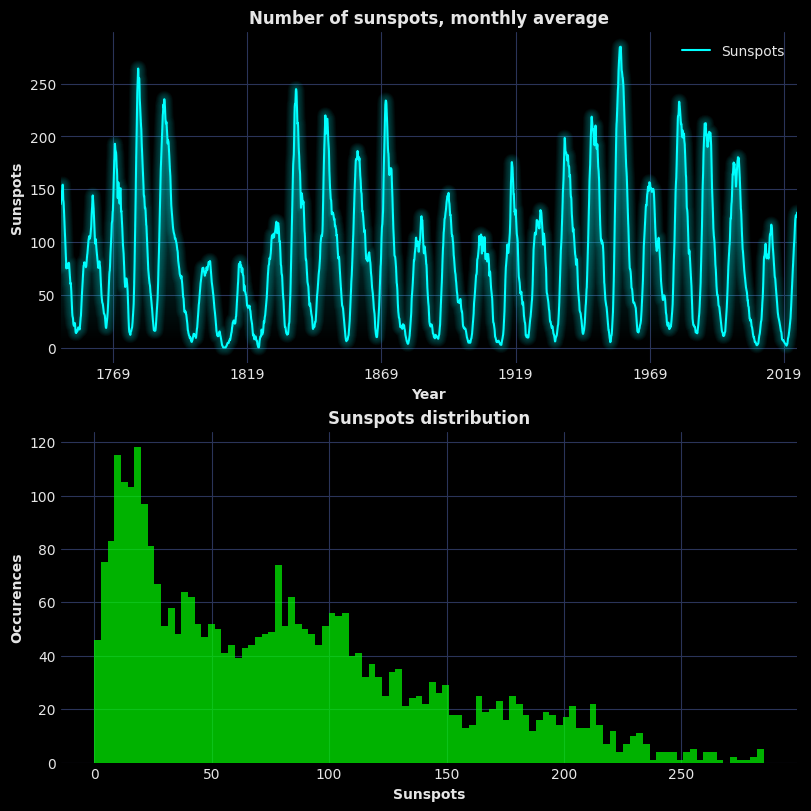

In [18]:
with plt.style.context('cyberpunk'):
    figure, axes = plt.subplots(2, 1, layout='constrained', figsize=(8, 8))
    dataset_month.plot(ax=axes[0], color='cyan')
    axes[0].set(title='Number of sunspots, monthly average', xlabel='Year', ylabel='Sunspots')
    enhance_plot(figure, axes[0], glow=True, alpha_gradient=0.5)
    axes[1].hist(dataset_month.Sunspots.values, bins=100, color='lime', alpha=0.7, align='mid')
    axes[1].set(xlabel='Sunspots', ylabel='Occurences', title='Sunspots distribution')
    enhance_plot(figure, axes[1])
figure.savefig('./images/image1.png')

# Estimating Frequency
By monthly data we expect approximately 132 month period (11 years). We use 2 methods:
* Using Lomb-Scargle Periodogram to estimate frequency
* Autocorrelation function (for this one we use yearly data)

Dominant period: 132.42156074014483 months


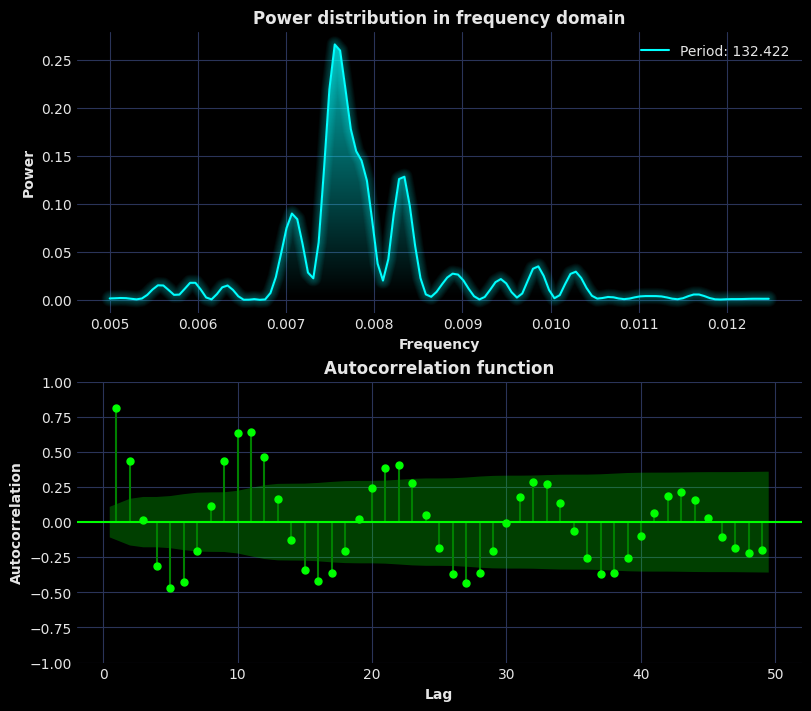

In [19]:
frequency, power = LombScargle(
    np.arange(len(dataset_month)),
    dataset_month.Sunspots.values
).autopower(minimum_frequency=1/200, maximum_frequency=1/80)
dominant_frequency = frequency[np.argmax(power)]
dominant_period_months = 1 / dominant_frequency
print(f"Dominant period: {dominant_period_months} months")
with plt.style.context('cyberpunk'):
    figure, axes = plt.subplots(2, 1, layout='constrained', figsize=(8, 7))
    axes[0].plot(frequency, power, color='cyan', label=f'Period: {dominant_period_months:.3f}')
    axes[0].set(xlabel='Frequency', ylabel='Power', title='Power distribution in frequency domain')
    axes[0].legend()
    enhance_plot(figure, axes[0], glow=True, alpha_gradient=0.7)
    plot_acf(dataset_year, ax=axes[1], color='lime', lags=range(1, 50), vlines_kwargs=dict(color='green'), title=None)
    set_polygon_color(axes[1], color='lime')
    axes[1].set(xlabel='Lag', ylabel='Autocorrelation', title='Autocorrelation function')
    enhance_plot(figure, axes[1])
figure.savefig('./images/image2.png')

# Monthly average decomposition

* Trend
* Seasonality
* Residuals

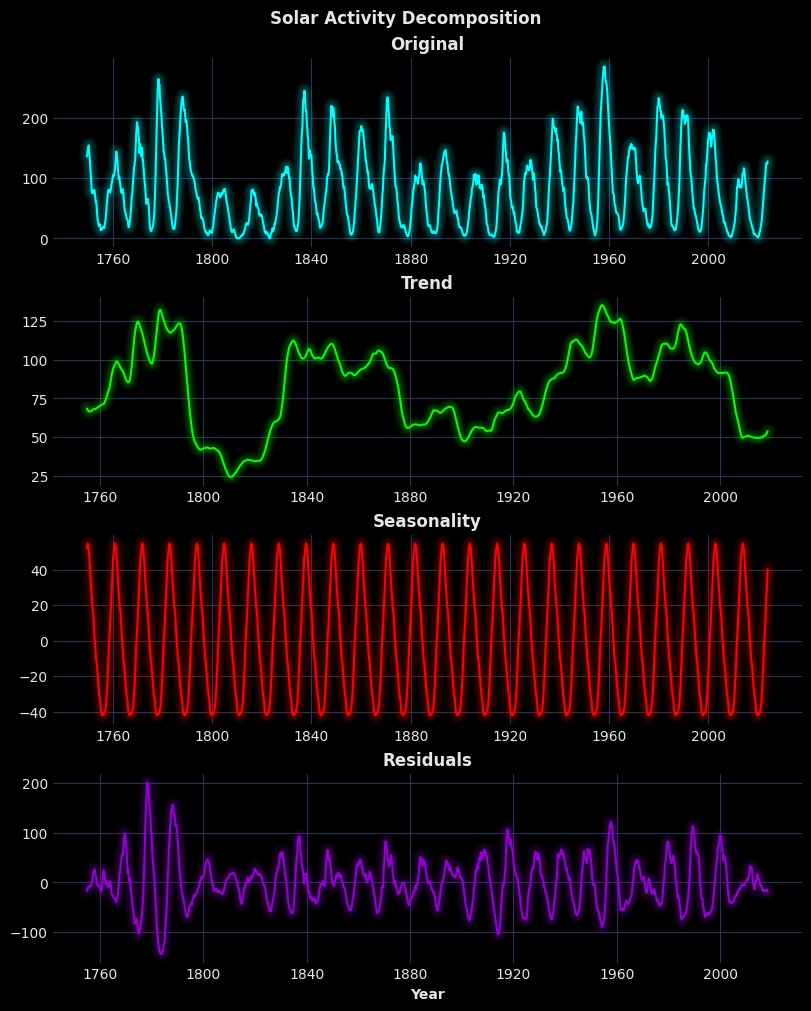

In [20]:
decomposition = seasonal_decompose(dataset_month.Sunspots, 
                                   model='additive', period=round(dominant_period_months))
with plt.style.context('cyberpunk'):
    figure, axes = plt.subplots(4, 1, layout='constrained', figsize=(8, 10))
    axes[0].plot(dataset_month, color='cyan')
    axes[1].plot(decomposition.trend, color='lime')
    axes[2].plot(decomposition.seasonal, color='red')
    axes[3].plot(decomposition.resid, color='darkviolet')
    for ax, name in zip(figure.axes, ['Original', 'Trend', 'Seasonality', 'Residuals']):
        ax.set(title=name)
        enhance_plot(figure, ax, glow=True)
    axes[-1].set(xlabel='Year')
    figure.suptitle('Solar Activity Decomposition', fontweight='bold')
figure.savefig('./images/image3.png')

# Differencing

We now use other methods of decomposing a time series of yearly data:
* First-Order differencing
* 11-Year differencing
* Combined differencing

We also conduct a Ljung-Box Test to check for any dependence

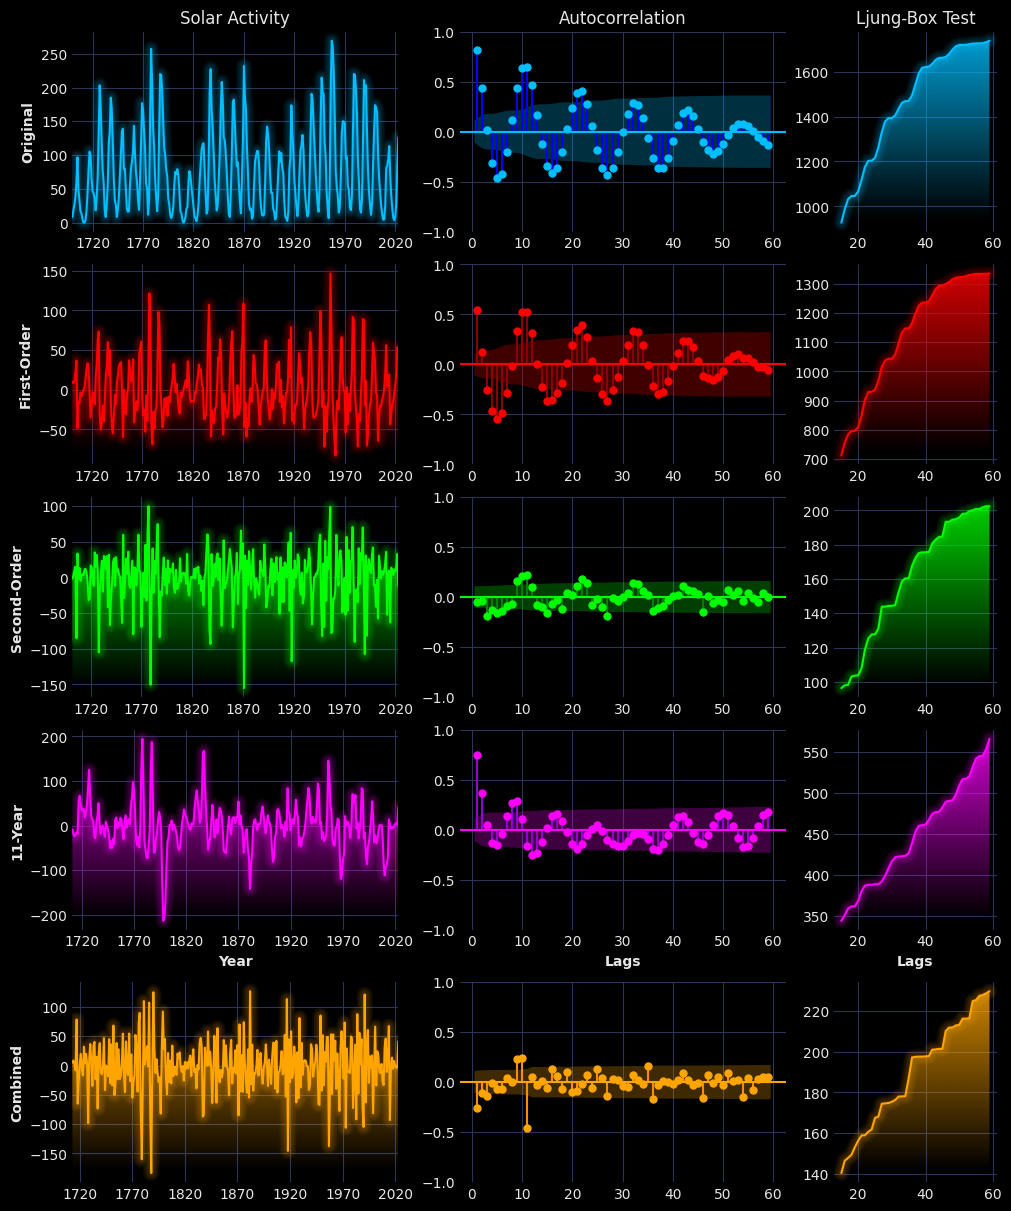

In [21]:
dataset_year_diff = dataset_year.diff().dropna()
dataset_year_diff2 = dataset_year_diff.diff().dropna()
dataset_year_seasonal_diff = dataset_year.diff(periods=int(dominant_period_months / 12)).dropna()
dataset_year_combined = dataset_year_seasonal_diff.diff().diff().dropna()

max_lag = 60
colors = [('blue', 'deepskyblue'), ('darkred', 'red'), 
          ('green', 'lime'), ('darkviolet', 'fuchsia'), ('darkorange', 'orange')]
titles = ['Original', 'First-Order', 'Second-Order', '11-Year', 'Combined']
series_list = [dataset_year, dataset_year_diff, dataset_year_diff2,
               dataset_year_seasonal_diff, dataset_year_combined]
with plt.style.context('cyberpunk'):
    figure, axes = plt.subplots(5, 3, layout='constrained', figsize=(10, 12), width_ratios=[2, 2, 1])
    for index, (series, title, (_, color)) in enumerate(zip(series_list, titles, colors)):
        series.plot(ax=axes[index, 0], color=color, legend=False)
        axes[index, 0].set(ylabel=title, xlabel=None)
        enhance_plot(figure, axes[index, 0], glow=True, alpha_gradient=0.8)
    axes[0, 0].set_title('Solar Activity')
    axes[3, 0].set(xlabel='Year')
    for index, (series, (bg_color, color)) in enumerate(zip(series_list, colors)):
        plot_acf(series, ax=axes[index, 1], lags=range(1, max_lag), color=color,
                 vlines_kwargs=dict(color=bg_color), title=None)
        set_polygon_color(axes[index, 1], color)
        enhance_plot(figure, axes[index, 1])
    axes[0, 1].set(title='Autocorrelation')
    axes[3, 1].set(xlabel='Lags')
    for index, (series, (_, color)) in enumerate(zip(series_list, colors)):
        acorr_ljungbox(series, lags=range(15, max_lag), return_df=True)\
        .lb_stat.plot(ax=axes[index, 2], color=color)
        enhance_plot(figure, axes[index, 2], glow=True, alpha_gradient=0.8)
    axes[0, 2].set(title='Ljung-Box Test')
    axes[3, 2].set(xlabel='Lags')
figure.savefig('./images/image4.png')

## Let's now compare residuals from both methods

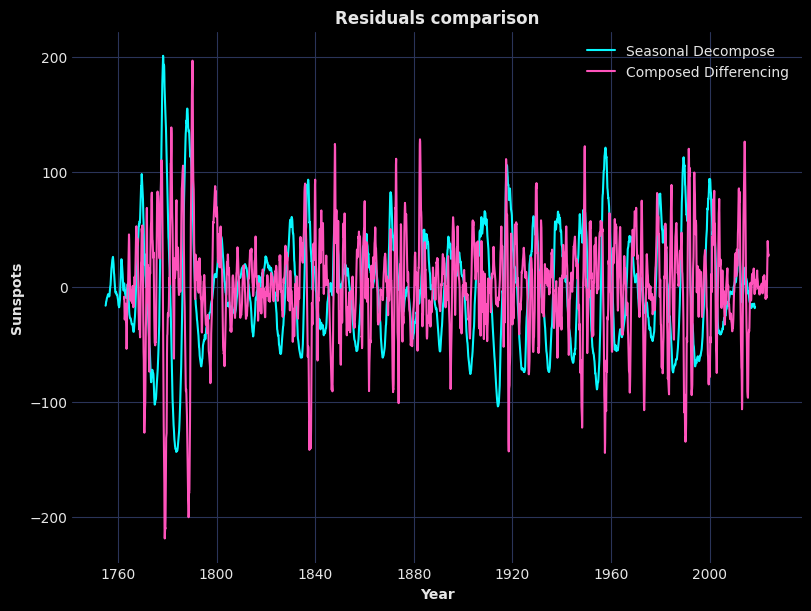

In [22]:
dataset_month_combined = (dataset_month.diff(periods=12).diff(periods=12)
                          .diff(periods=int(dominant_period_months)))
with plt.style.context('cyberpunk'):
    figure, axes = plt.subplots(1, 1, layout='constrained', figsize=(8, 6))
    axes.plot(decomposition.resid, label='Seasonal Decompose')
    axes.plot(dataset_month_combined, label='Composed Differencing')
    axes.set(xlabel='Year', ylabel='Sunspots', title='Residuals comparison')
    axes.legend()
    enhance_plot(figure, axes)
figure.savefig('./images/image5.png')

# Extracting a trend in sunspots peaks

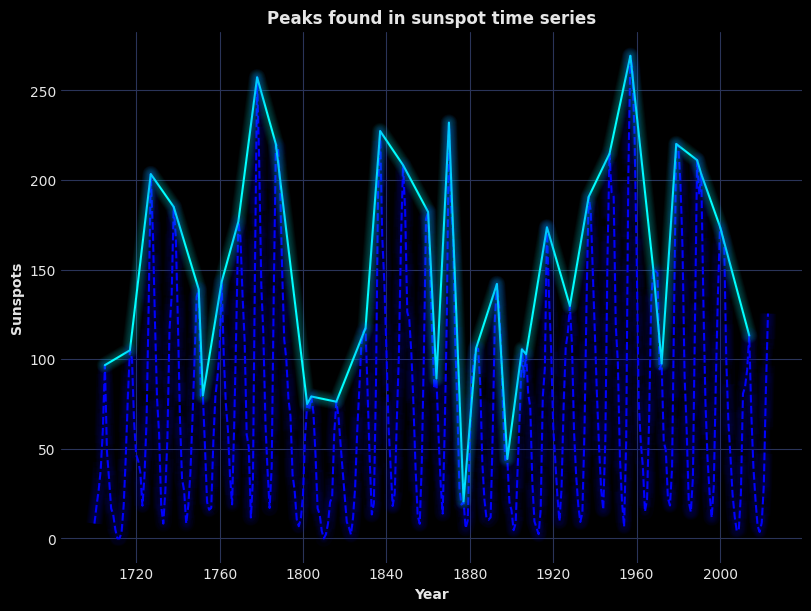

In [23]:
peaks, _ = find_peaks(dataset_year.Sunspots.values)
with plt.style.context('cyberpunk'):
    figure, axes = plt.subplots(1, 1, layout='constrained', figsize=(8, 6))
    axes.plot(dataset_year, color='blue', linestyle='--', label='Sunspot Data')
    axes.plot(dataset_year.iloc[peaks], color='cyan', label='Sunspot Peaks')
    axes.set(xlabel='Year', ylabel='Sunspots', title='Peaks found in sunspot time series')
    enhance_plot(figure, axes, glow=True)
figure.savefig('./images/image6.png')